In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output

  !pip install transformers evaluate wandb datasets accelerate  -U -qq  ## NEW LINES ##

  basepath = '/content/drive/MyDrive/utd_classes/Sem3/NLP/HWs'
else:
  basepath = '/Users/rucheekkashyap/utd_classes/Sem3/NLP/HWs/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

### NEW ##########################
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

# wandb library
import wandb

In [3]:
#initialize wandb
import wandb
wandb.login()
wandb.init(project="distilroberta-base-training", name="imbalanced_distilroberta_finetuning")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: rucheekkashyap (rucheekkashyap-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


In [4]:
base_folder = Path(basepath)
data_folder = base_folder/'HW5'
model_folder = base_folder/'HW5'
#custom_functions = base_folder/'custom-functions'

In [5]:
model_folder.mkdir(exist_ok=True, parents = True)

In [6]:
model_folder

PosixPath('/content/drive/MyDrive/utd_classes/Sem3/NLP/HWs/HW5')

In [7]:
import pandas as pd

# Load the train and test datasets from CSV files
train_df = pd.read_csv(data_folder / 'train.csv')
test_df = pd.read_csv(data_folder / 'test.csv')


In [8]:
from sklearn.model_selection import train_test_split

# Split the train dataset into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [9]:
# Display the first few rows of each dataset
print("Train Dataset:")
print(train_df.head())

print("\nValidation Dataset:")
print(val_df.head())

print("\nTest Dataset:")
print(test_df.head())


Train Dataset:
              ID                                              Tweet  anger  \
4291  2017-20959  Going to get myself a copy of @StephenKing's C...      0   
1210  2017-30404  @carysmithwriter @Maria_Savva @RealRockAndRoll...      0   
1940  2017-20271  Unruly kids at 8am in the morning #nothanks ri...      1   
6204  2017-10419  Ok but I just got called a 'White Devil' on th...      0   
2867  2017-30687  @SXMUrbanView @karenhunter @CousinSyl you are ...      1   

      anticipation  disgust  fear  joy  love  optimism  pessimism  sadness  \
4291             1        0     0    1     0         1          0        0   
1210             0        0     0    1     1         1          0        0   
1940             0        1     1    0     0         0          0        0   
6204             0        0     1    0     0         0          0        0   
2867             0        1     0    0     0         0          0        0   

      surprise  trust  
4291         0      0  

In [10]:
X_train_df = train_df['Tweet']
y_train_df = train_df.drop(columns=['ID','Tweet'], axis=1)

X_valid_df = val_df['Tweet']
y_valid_df = val_df.drop(columns=['ID','Tweet'], axis=1)

X_test_df = test_df['Tweet']
y_test_df = test_df.drop(columns=['ID','Tweet'], axis=1)

X_train_df.head(), y_train_df.head()

(4291    Going to get myself a copy of @StephenKing's C...
 1210    @carysmithwriter @Maria_Savva @RealRockAndRoll...
 1940    Unruly kids at 8am in the morning #nothanks ri...
 6204    Ok but I just got called a 'White Devil' on th...
 2867    @SXMUrbanView @karenhunter @CousinSyl you are ...
 Name: Tweet, dtype: object,
       anger  anticipation  disgust  fear  joy  love  optimism  pessimism  \
 4291      0             1        0     0    1     0         1          0   
 1210      0             0        0     0    1     1         1          0   
 1940      1             0        1     1    0     0         0          0   
 6204      0             0        0     1    0     0         0          0   
 2867      1             0        1     0    0     0         0          0   
 
       sadness  surprise  trust  
 4291        0         0      0  
 1210        0         0      0  
 1940        0         1      0  
 6204        0         1      0  
 2867        0         0      0  )

In [11]:
# Step 1: Tokenize the Text Data
from transformers import RobertaTokenizer

# Load the tokenizer for RoBERTa
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Define a function to tokenize the dataset
def tokenize_data(texts):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

# Tokenize both the training and validation data
train_encodings = tokenize_data(list(X_train_df))
val_encodings = tokenize_data(list(X_valid_df))

# Map labels from DataFrames
train_labels = y_train_df.values.tolist()
val_labels = y_valid_df.values.tolist()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
# Step 2: Handling Imbalance in Training Data
# Calculate class weights for each label column
from sklearn.utils.class_weight import compute_class_weight
class_weights_dict = {}
for col in y_train_df.columns:
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_df[col]), y=y_train_df[col])
    class_weights_dict[col] = dict(zip(np.unique(y_train_df[col]), class_weights))

# Display the calculated class weights
print("Class Weights for each label:")
for col, weights in class_weights_dict.items():
    print(f"{col}: {weights}")

Class Weights for each label:
anger: {0: 0.7938078108941419, 1: 1.3508963707914299}
anticipation: {0: 0.5830345348178901, 1: 3.5107954545454545}
disgust: {0: 0.801634665282823, 1: 1.3288172043010753}
fear: {0: 0.6033001366920523, 1: 2.920132325141777}
joy: {0: 0.8001813001813002, 1: 1.332830025884383}
love: {0: 0.5619316114950891, 1: 4.536710719530102}
optimism: {0: 0.7149965285813469, 1: 1.6628094725511302}
pessimism: {0: 0.5647048071650521, 1: 4.363700564971752}
sadness: {0: 0.7076271186440678, 1: 1.7040816326530612}
surprise: {0: 0.5278489663420468, 1: 9.476993865030675}
trust: {0: 0.5262306251064555, 1: 10.030844155844155}


In [13]:
# Step 3: Prepare Hugging Face Datasets
# Define datasets as dictionaries
trainset = Dataset.from_dict({
    'texts': X_train_df.tolist(),
    **{col: y_train_df[col].tolist() for col in y_train_df.columns}
})

validset = Dataset.from_dict({
    'texts': X_valid_df.tolist(),
    **{col: y_valid_df[col].tolist() for col in y_valid_df.columns}
})

testset = Dataset.from_dict({
    'texts': X_test_df.tolist(),
    **{col: y_test_df[col].tolist() for col in y_test_df.columns}
})

In [14]:
trainset.features

{'texts': Value(dtype='string', id=None),
 'anger': Value(dtype='int64', id=None),
 'anticipation': Value(dtype='int64', id=None),
 'disgust': Value(dtype='int64', id=None),
 'fear': Value(dtype='int64', id=None),
 'joy': Value(dtype='int64', id=None),
 'love': Value(dtype='int64', id=None),
 'optimism': Value(dtype='int64', id=None),
 'pessimism': Value(dtype='int64', id=None),
 'sadness': Value(dtype='int64', id=None),
 'surprise': Value(dtype='int64', id=None),
 'trust': Value(dtype='int64', id=None)}

In [15]:
from transformers.modeling_outputs import SequenceClassifierOutput
import json  # Ensure this is imported for JSON handling

# Define configuration for the distilroberta-base model
class CustomConfig:
    def __init__(self, num_labels=11):
        self.num_labels = num_labels

    def to_dict(self):
        return {'num_labels': self.num_labels}

    def to_json_string(self):
        return json.dumps(self.to_dict())

    @classmethod
    def from_dict(cls, config_dict):
        return cls(**config_dict)

    @classmethod
    def from_json_string(cls, json_string):
        config_dict = json.loads(json_string)
        return cls.from_dict(config_dict)



In [16]:
# Custom DistilRoBERTa model for sequence classification
class CustomDistilRobertaModel:
    def __init__(self, config):
        # Initialize the DistilRoBERTa model for sequence classification
        self.model = DistilRobertaForSequenceClassification.from_pretrained(
            'distilroberta-base',
            num_labels=config.num_labels
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Forward pass through DistilRoBERTa model
        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        return outputs

    def predict(self, test_loader, threshold=0.5):
        self.model.eval()
        all_predictions = []
        all_probabilities = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.model.device)
                attention_mask = batch['attention_mask'].to(self.model.device)

                # Forward pass
                outputs = self.model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                # Convert logits to probabilities
                probabilities = torch.sigmoid(logits)

                # Threshold to get binary predictions
                predictions = (probabilities >= threshold).float()

                all_predictions.append(predictions.cpu())
                all_probabilities.append(probabilities.cpu())

        all_predictions = torch.cat(all_predictions, dim=0)
        all_probabilities = torch.cat(all_probabilities, dim=0)

        return all_predictions, all_probabilities


In [17]:
# Define collate_batch for DistilRoBERTa-based model
def collate_batch(batch):
    """
    Prepares a batch of data by tokenizing texts and converting labels into a tensor.

    Args:
        batch (list of dict): A batch of data where each element is a dictionary with keys
                              'labels' and 'texts'. 'labels' are the emotion labels, and
                              'texts' are the corresponding texts.

    Returns:
        dict: A dictionary with three keys:
              - 'input_ids': a tensor containing token IDs.
              - 'attention_mask': a tensor that masks the padding tokens.
              - 'labels': a tensor of the labels for each text in the batch.
    """
    # Process labels and texts from batch samples
    labels = [
        [
            int(sample.get('anger', 0)) if sample.get('anger', 0) != 'NONE' else 0,
            int(sample.get('anticipation', 0)) if sample.get('anticipation', 0) != 'NONE' else 0,
            int(sample.get('disgust', 0)) if sample.get('disgust', 0) != 'NONE' else 0,
            int(sample.get('fear', 0)) if sample.get('fear', 0) != 'NONE' else 0,
            int(sample.get('joy', 0)) if sample.get('joy', 0) != 'NONE' else 0,
            int(sample.get('love', 0)) if sample.get('love', 0) != 'NONE' else 0,
            int(sample.get('optimism', 0)) if sample.get('optimism', 0) != 'NONE' else 0,
            int(sample.get('pessimism', 0)) if sample.get('pessimism', 0) != 'NONE' else 0,
            int(sample.get('sadness', 0)) if sample.get('sadness', 0) != 'NONE' else 0,
            int(sample.get('surprise', 0)) if sample.get('surprise', 0) != 'NONE' else 0,
            int(sample.get('trust', 0)) if sample.get('trust', 0) != 'NONE' else 0,
        ]
        for sample in batch
    ]
    texts = [sample['texts'] for sample in batch]

    # Tokenize texts using DistilRoBERTa tokenizer
    encodings = tokenizer(
        texts,
        padding=True,           # Pads sequences to the same length within a batch
        truncation=True,
        max_length=128,         # Adjust based on your task requirements
        return_tensors="pt"     # Returns PyTorch tensors
    )

    # Convert labels to a tensor
    labels = torch.tensor(labels, dtype=torch.float32)

    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    }


In [18]:
from transformers import Trainer

# Define the loss function for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# Define the CustomTrainer class for DistilRoBERTa
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Forward pass: Get logits from the model
        outputs = model(**inputs)
        logits = outputs.logits  # Extract logits

        # Extract labels from inputs
        labels = inputs['labels']  # Ensure labels are of shape [batch_size, num_labels]

        # Calculate the loss using BCEWithLogitsLoss for multi-label classification
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [19]:
from sklearn.metrics import f1_score
import torch

def compute_metrics(eval_pred):
    """
    Computes the F1 macro-average score for multi-label classification.

    Args:
        eval_pred (tuple): A tuple of logits and true labels from the model.

    Returns:
        dict: Dictionary containing the macro F1 score.
    """
    logits, labels = eval_pred
    # Convert logits to probabilities using the sigmoid function for multi-label classification
    probabilities = torch.sigmoid(torch.tensor(logits))

    # Apply thresholding at 0.5 for binary predictions
    predictions = (probabilities > 0.5).int().numpy()

    # Ensure labels are in numpy array form if not already
    labels = labels.numpy() if isinstance(labels, torch.Tensor) else labels

    # Calculate F1 macro-average score
    f1_macro = f1_score(labels, predictions, average="macro", zero_division=0)

    return {"f1_macro": f1_macro}


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

# Initialize the DistilRoBERTa tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

# Configure the model for multi-label classification with num_labels and label mappings
my_config = AutoConfig.from_pretrained(
    'distilroberta-base',
    num_labels=11  # Number of emotion labels
)
my_config.id2label = {i: label for i, label in enumerate(['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'])}
my_config.label2id = {label: i for i, label in my_config.id2label.items()}

# Initialize DistilRoBERTa model for sequence classification with the custom configuration
model = AutoModelForSequenceClassification.from_pretrained('distilroberta-base', config=my_config)



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=20,
    per_device_train_batch_size=64, # Number of samples per training batch
    per_device_eval_batch_size=64, # Number of samples per validation batch
    weight_decay=0.01, # weight decay (L2 regularization)
    learning_rate=0.0001, # learning arte
    optim='adamw_torch', # optimizer
    remove_unused_columns=False, # flag to retain unused columns

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'f1_macro' as the metric to determine the best model
    metric_for_best_model="f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name='distilbert-base-uncased_trainer',  # Experiment name for Weights & Biases
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainset,
    eval_dataset=validset,
    data_collator=collate_batch,
    compute_metrics=compute_metrics,
)

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,F1 Macro
50,0.459100,0.398192,0.293490
100,0.372600,0.356891,0.385727
150,0.321100,0.332453,0.448079
200,0.313100,0.333977,0.491550
250,0.277800,0.335269,0.493471
300,0.262900,0.335700,0.534914
350,0.240000,0.331701,0.524221
400,0.230500,0.341235,0.533106
450,0.206500,0.339012,0.535989
500,0.202400,0.367962,0.552073


TrainOutput(global_step=1940, training_loss=0.13110561843999882, metrics={'train_runtime': 317.1249, 'train_samples_per_second': 389.689, 'train_steps_per_second': 6.117, 'total_flos': 1703196841241322.0, 'train_loss': 0.13110561843999882, 'epoch': 20.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.4839988350868225,
 'eval_f1_macro': 0.5604681667627893,
 'eval_runtime': 0.7299,
 'eval_samples_per_second': 2116.633,
 'eval_steps_per_second': 34.25,
 'epoch': 20.0}

In [25]:
valid_output = trainer.predict(validset)
valid_output._fields

('predictions', 'label_ids', 'metrics')

In [26]:
# Assuming valid_output.predictions contains the raw logits
valid_preds = (torch.sigmoid(torch.tensor(valid_output.predictions)) > 0.5).int().numpy()
valid_labels = np.array(valid_output.label_ids)


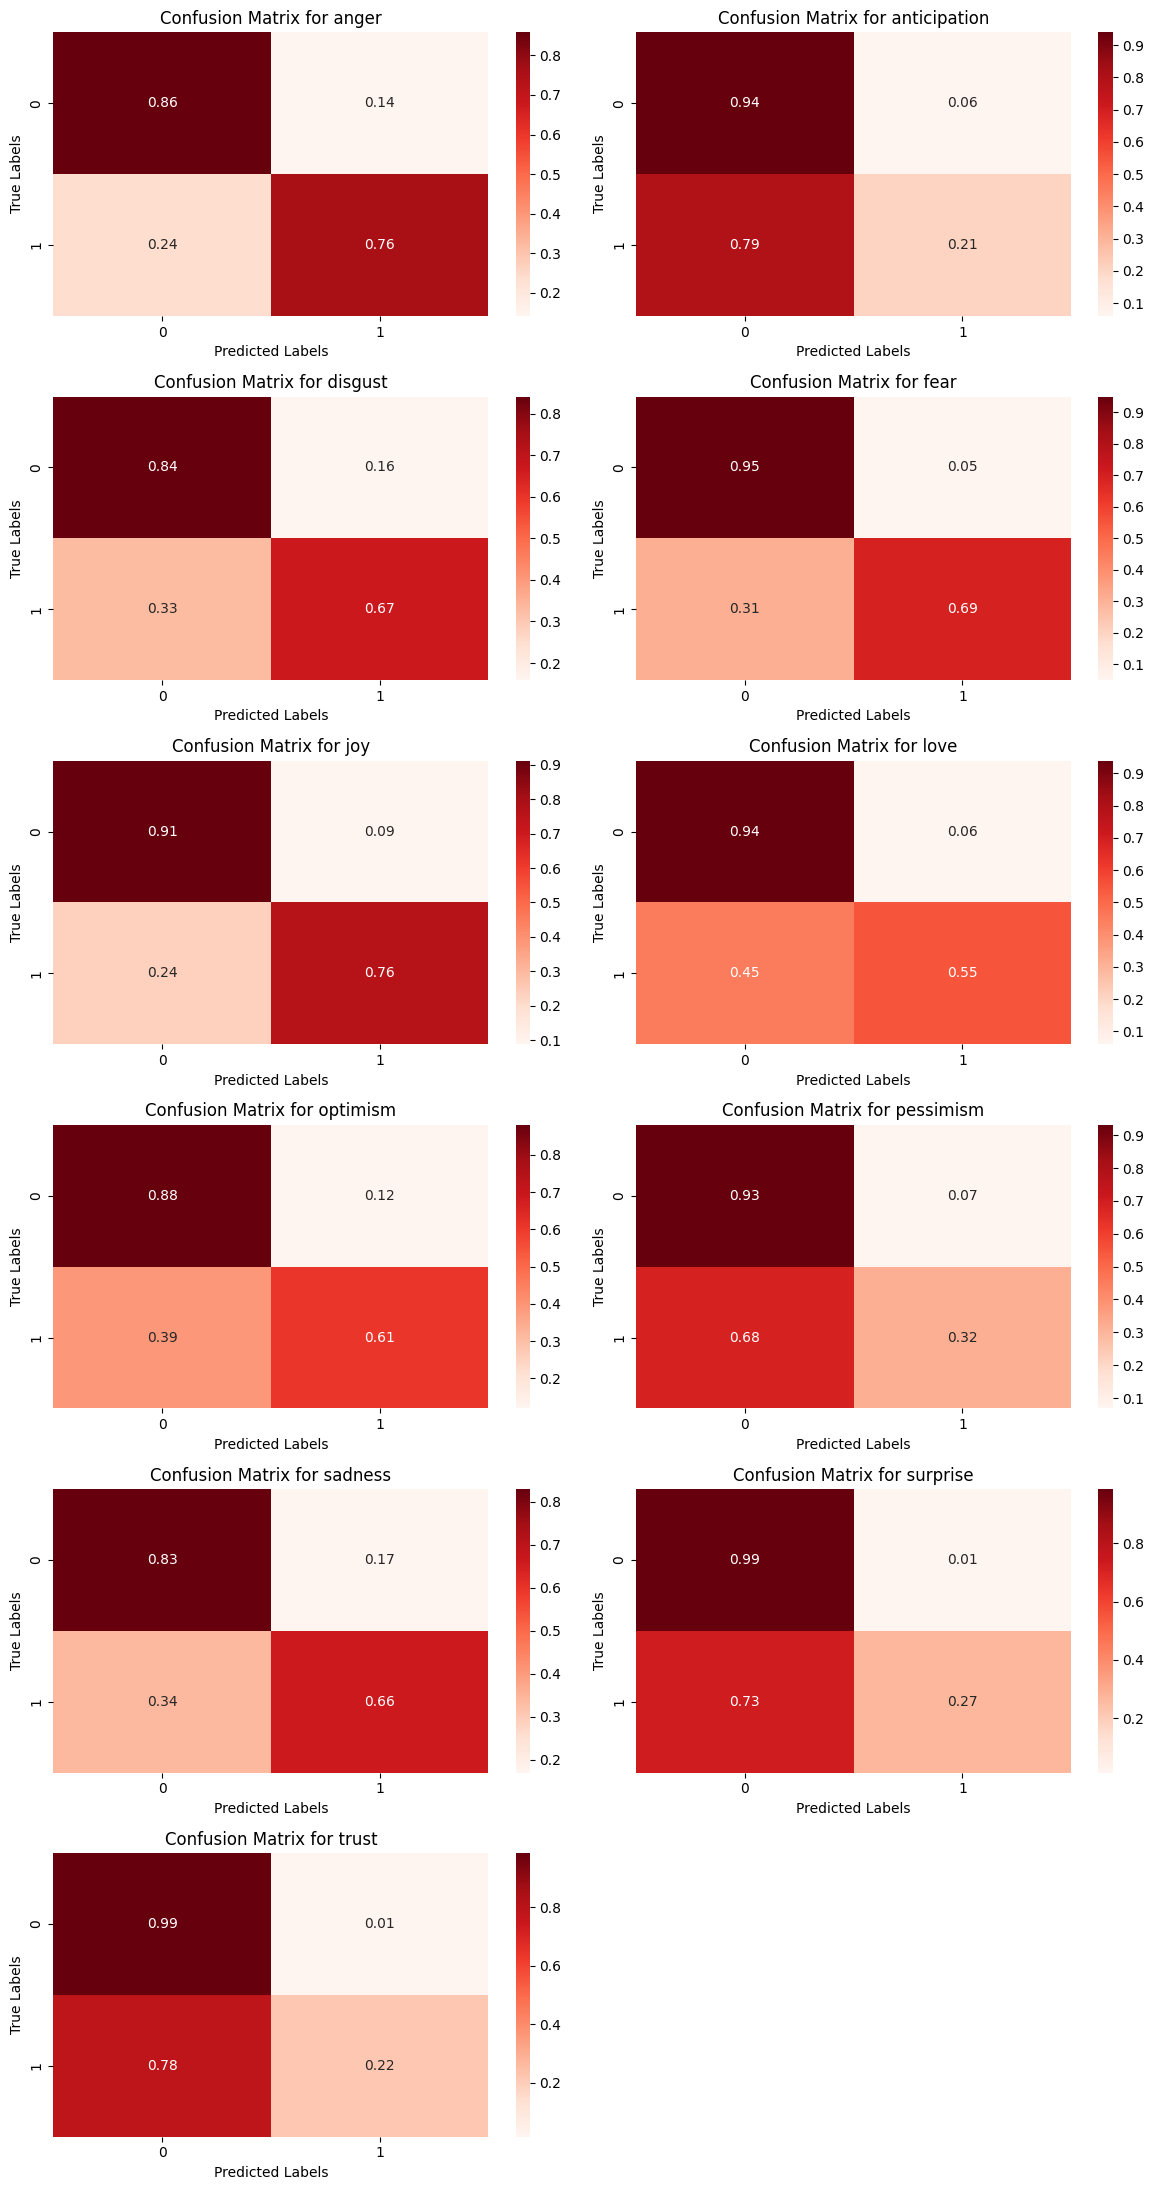

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert valid_output to numpy arrays
valid_labels_np = np.array(valid_output.label_ids)  # Shape: (n_samples, n_classes)
valid_preds_np = np.array(valid_output.predictions)  # Shape: (n_samples, n_classes)

# Convert probabilities to binary predictions
threshold = 0.5
valid_preds_np = (valid_preds_np > threshold).astype(int)  # Shape: (n_samples, n_classes)

def plot_multilabel_confusion_matrix(valid_labels, valid_preds, class_labels):
    """
    Plots confusion matrices for each class in multilabel classification.

    Args:
        valid_labels (array-like): True labels of the validation data (shape: [n_samples, n_classes]).
        valid_preds (array-like): Predicted labels of the validation data (shape: [n_samples, n_classes]).
        class_labels (list): List of class names for the labels.
    """
    n_classes = len(class_labels)

    # Create a figure to hold all the subplots
    fig, axes = plt.subplots(nrows=(n_classes + 1) // 2, ncols=2, figsize=(12, n_classes * 2))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(n_classes):
        # Compute the confusion matrix for each class
        cm = confusion_matrix(valid_labels[:, i], valid_preds[:, i], normalize='true')

        # Plot the confusion matrix using Seaborn
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", ax=ax,
                    xticklabels=["0", "1"], yticklabels=["0", "1"])

        ax.set_title(f'Confusion Matrix for {class_labels[i]}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

    # Remove any empty subplots
    for j in range(n_classes, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout
    plt.show()

# Call the function with the converted multilabel data
plot_multilabel_confusion_matrix(valid_labels_np, valid_preds_np, class_labels=list(my_config.id2label.values()))


In [28]:
import wandb

# Assuming valid_labels and valid_preds are already defined as 2D arrays
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Loop through each label and log its confusion matrix separately
for i, class_name in enumerate(class_names):
    # Extract predictions and true labels for the current label
    class_preds = valid_preds[:, i]
    class_true = valid_labels[:, i]

    # Log confusion matrix to Wandb for the current class
    wandb.log({
        f"conf_matrix_{class_name}": wandb.plot.confusion_matrix(
            preds=class_preds,
            y_true=class_true,
            class_names=["0", "1"]
        )
    })


In [29]:
# Retrieve the best model checkpoint
best_model_checkpoint = trainer.state.best_model_checkpoint

# Check if a best checkpoint was found
if best_model_checkpoint is not None:
    best_model_checkpoint_step = best_model_checkpoint.split('-')[-1]
    print(f"The best model was saved at step {best_model_checkpoint_step}.")
else:
    print("No best model checkpoint found.")


The best model was saved at step 1150.


In [30]:
wandb.finish

<function wandb.sdk.wandb_run.finish(exit_code: 'int | None' = None, quiet: 'bool | None' = None) -> 'None'>

In [31]:
# Make predictions on the test set
predictions = trainer.predict(testset)
predictions._fields

('predictions', 'label_ids', 'metrics')

In [32]:
# Extract the predicted logits
pred_logits = predictions.predictions

# Apply sigmoid to the logits to convert them into probabilities
pred_probs = torch.sigmoid(torch.tensor(pred_logits))

# Convert probabilities into binary labels (threshold at 0.5)
pred_labels = (pred_probs > 0.5).int().numpy()  # Convert to numpy array with 0s and 1s

In [33]:
pred_labels

array([[1, 0, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0]], dtype=int32)

In [34]:
# Assuming valid_output.predictions contains the raw logits
test_preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()
test_labels = np.array(predictions.label_ids)


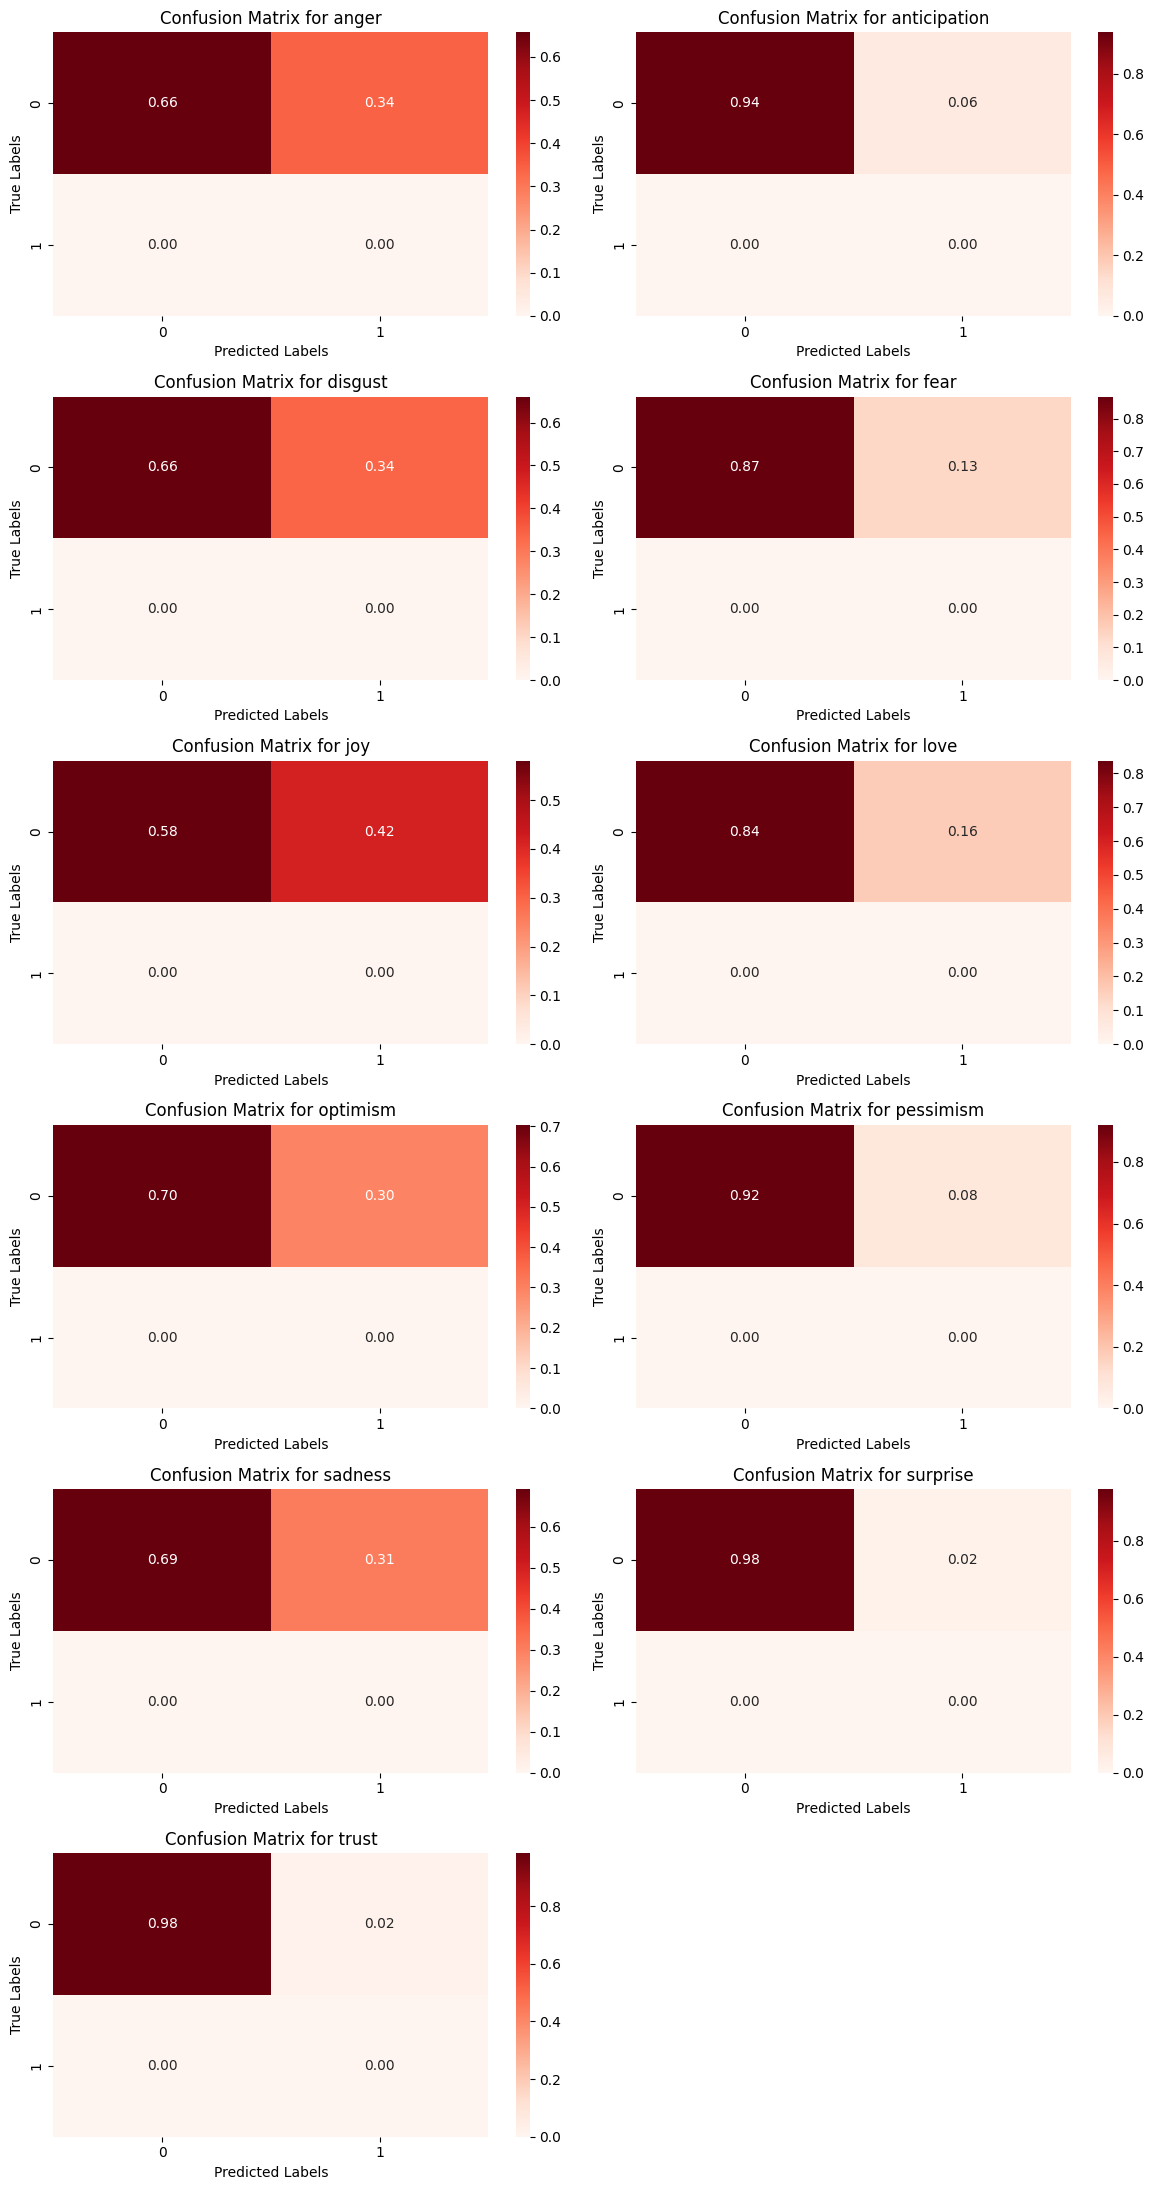

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert valid_output to numpy arrays
test_labels_np = np.array(predictions.label_ids)  # Shape: (n_samples, n_classes)
test_preds_np = np.array(predictions.predictions)  # Shape: (n_samples, n_classes)

# Convert probabilities to binary predictions
threshold = 0.5
test_preds_np = (test_preds_np > threshold).astype(int)  # Shape: (n_samples, n_classes)

def plot_multilabel_confusion_matrix(test_labels, test_preds, class_labels):
    """
    Plots confusion matrices for each class in multilabel classification.

    Args:
        valid_labels (array-like): True labels of the validation data (shape: [n_samples, n_classes]).
        valid_preds (array-like): Predicted labels of the validation data (shape: [n_samples, n_classes]).
        class_labels (list): List of class names for the labels.
    """
    n_classes = len(class_labels)

    # Create a figure to hold all the subplots
    fig, axes = plt.subplots(nrows=(n_classes + 1) // 2, ncols=2, figsize=(12, n_classes * 2))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(n_classes):
        # Compute the confusion matrix for each class
        cm = confusion_matrix(test_labels[:, i], test_preds[:, i], normalize='true')

        # Plot the confusion matrix using Seaborn
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Reds", ax=ax,
                    xticklabels=["0", "1"], yticklabels=["0", "1"])

        ax.set_title(f'Confusion Matrix for {class_labels[i]}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

    # Remove any empty subplots
    for j in range(n_classes, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Adjust layout
    plt.show()

# Call the function with the converted multilabel data
plot_multilabel_confusion_matrix(test_labels_np, test_preds_np, class_labels=list(my_config.id2label.values()))
